# ML2 Assignment 1 – Bike Demand Prediction

## Overview


# Overview

The objective of this project is to apply MLOps principles to design, evaluate, and operationalise machine learning models for forecasting daily bike rental demand. The Bike Sharing Daily dataset, which contains historical rental records from the Capital Bikeshare system in Washington, D.C., for the years 2011 and 2012, was utilised for this assignment. The dataset includes calendar-related, seasonal, and environmental variables such as temperature, humidity, weather conditions, working day status, and holiday indicators.

The main goals of this project are to develop reliable regression models using the 2011 dataset, analyse the impact of data drift using the 2012 dataset, and implement automated quality control mechanisms. MLOps practices such as experiment tracking, model versioning, and automated testing are incorporated to ensure reproducibility and long-term reliability.

This assignment is structured into three tasks. Task 1 focuses on model development and experiment design. Task 2 analyses temporal data drift and its impact on performance. Task 3 implements automation pipelines for model quality control.



## Task 1: Model Development

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df_2011 = pd.read_csv("day_2011.csv")
df_2012 = pd.read_csv("day_2012.csv")

# Preview
df_2011.head()


,dteday,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01/01/2011,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,02/01/2011,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,03/01/2011,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,04/01/2011,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,05/01/2011,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [5]:
df_2011.info()
df_2011.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      365 non-null    object 
 1   season      365 non-null    int64  
 2   mnth        365 non-null    int64  
 3   holiday     365 non-null    int64  
 4   weekday     365 non-null    int64  
 5   workingday  365 non-null    int64  
 6   weathersit  365 non-null    int64  
 7   temp        365 non-null    float64
 8   atemp       365 non-null    float64
 9   hum         365 non-null    float64
 10  windspeed   365 non-null    float64
 11  cnt         365 non-null    int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 34.3+ KB


,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2.498630,6.526027,0.027397,3.008219,0.684932,1.421918,0.486665,0.466835,0.643665,0.191403,3405.761644
std,1.110946,3.452584,0.163462,2.006155,0.465181,0.571831,0.189596,0.168836,0.148744,0.076890,1378.753666
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,431.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.325000,0.321954,0.538333,0.135583,2132.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.479167,0.472846,0.647500,0.186900,3740.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.656667,0.612379,0.742083,0.235075,4586.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.849167,0.840896,0.972500,0.507463,6043.000000


## 1.1 Data Preprocessing and Cleaning

Prior to model development, data quality checks were conducted to assess completeness and consistency.

### Data Validation

- Missing values were checked using `isnull()` and none were found.
- Duplicate records were examined using `duplicated()` and none were detected.
- All variables were numerical and within valid ranges.

In [132]:
# Missing values
df_2011.isnull().sum()



season        0
holiday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
month         0
day           0
weekday       0
dtype: int64

In [122]:
# Duplicates
df_2011.duplicated().sum()

0

### Date Processing and Feature Engineering

The `dteday` column was converted to datetime format. Temporal features were extracted:

- Year  
- Month  
- Day  
- Weekday  

Redundant attributes (`mnth`, `weekday`, `year` and `dteday`) were removed to prevent duplication and multicollinearity.

### Outlier Handling

Extreme rental counts were retained as they represent genuine high-demand periods rather than measurement errors.



In [6]:
# Convert date
df_2011['dteday'] = pd.to_datetime(df_2011['dteday'], dayfirst=True)

# Extract time features
df_2011['year'] = df_2011['dteday'].dt.year
df_2011['month'] = df_2011['dteday'].dt.month
df_2011['day'] = df_2011['dteday'].dt.day
df_2011['weekday_new'] = df_2011['dteday'].dt.weekday

# Drop original time columns
df_2011 = df_2011.drop(columns=['dteday', 'mnth', 'weekday'])

# Rename for clarity
df_2011 = df_2011.rename(columns={'weekday_new': 'weekday'})




In [7]:
df_2011.info()
df_2011.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      365 non-null    int64  
 1   holiday     365 non-null    int64  
 2   workingday  365 non-null    int64  
 3   weathersit  365 non-null    int64  
 4   temp        365 non-null    float64
 5   atemp       365 non-null    float64
 6   hum         365 non-null    float64
 7   windspeed   365 non-null    float64
 8   cnt         365 non-null    int64  
 9   year        365 non-null    int32  
 10  month       365 non-null    int32  
 11  day         365 non-null    int32  
 12  weekday     365 non-null    int32  
dtypes: float64(4), int32(4), int64(5)
memory usage: 31.5 KB


,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,day,weekday
0,1,0,0,2,0.344167,0.363625,0.805833,0.160446,985,2011,1,1,5
1,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,2011,1,2,6
2,1,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,2011,1,3,0
3,1,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,2011,1,4,1
4,1,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,2011,1,5,2


In [8]:
df_2011.columns


Index(['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'cnt', 'year', 'month', 'day', 'weekday'],
      dtype='object')

In [52]:
df_2011 = df_2011.drop(columns=['year'])


## 1.2 Exploratory Data Analysis

A correlation analysis was conducted to examine relationships between features and rental demand.

Key observations:

- Temperature and apparent temperature showed strong positive correlations.
- Humidity showed moderate negative correlation.
- Calendar-related features showed weaker relationships.

These results indicate that weather conditions strongly influence bike usage.

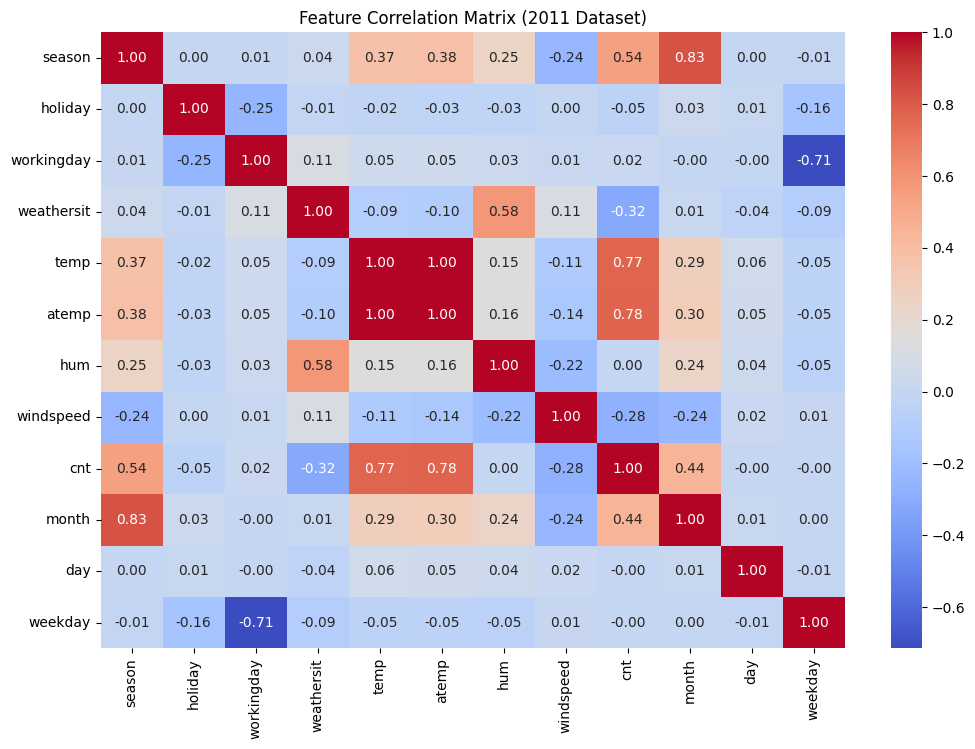

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

corr_matrix = df_2011.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.title("Feature Correlation Matrix (2011 Dataset)")
plt.show()


## 1.3 Experimental Setup

The target variable was defined as `cnt`, representing total daily rentals. All remaining variables were used as predictors.

The dataset was split into training and validation sets using an 80:20 ratio.

MLflow was configured to track experiments, parameters, metrics, and model artefacts.

In [54]:
# Features and target
X = df_2011.drop(columns=['cnt'])
y = df_2011['cnt']

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [58]:
import mlflow
import mlflow.sklearn

# Connect to local MLflow server
mlflow.set_tracking_uri("http://localhost:5000")

# Set experiment
EXPERIMENT_NAME = "Bike_Demand_2011"
mlflow.set_experiment(EXPERIMENT_NAME)

print("Tracking URI:", mlflow.get_tracking_uri())


C:\Users\teojinrui\anaconda3\Lib\site-packages\pydantic\_internal\_fields.py:161: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
2026/02/07 21:10:56 INFO mlflow.tracking.fluent: Experiment with name 'Bike_Demand_2011' does not exist. Creating a new experiment.


Tracking URI: http://localhost:5000


## 1.4 Baseline Model: Linear Regression

A linear regression model was used as the baseline due to its simplicity and interpretability.

### Results

- RMSE ≈ 691  
- MAE ≈ 503  
- R² ≈ 0.74  

The baseline model explained approximately 74% of the variance in demand.

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


with mlflow.start_run(run_name="Baseline_Linear_Regression"):


    # Model Training
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)


    # Prediction
    preds = model_lr.predict(X_val)


    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)


    # Log Parameters
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("fit_intercept", model_lr.fit_intercept)
    mlflow.log_param("normalize", False)  # for documentation


    # Log Metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)

  
    # Log Model Artifact
    mlflow.sklearn.log_model(
        sk_model=model_lr,
        artifact_path="model",
        registered_model_name=None  
    )

    
    print("Baseline Model Performance")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")


2026/02/07 21:15:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Baseline Model Performance
RMSE: 691.26
MAE : 503.07
R²  : 0.7440
🏃 View run Baseline_Linear_Regression at: http://localhost:5000/#/experiments/172962115451043892/runs/d2e5dd5173844dbb9e65fcca8d31b5c0
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


## 1.5 Improved Model: Ridge Regression

Ridge regression was implemented to reduce potential multicollinearity through L2 regularisation.

### Results

- RMSE ≈ 677  
- MAE ≈ 502  
- R² ≈ 0.75  

The Ridge model showed marginal improvement over the baseline.

In [62]:
from sklearn.linear_model import Ridge

with mlflow.start_run(run_name="Improved_Ridge_Regression"):

    # Train model
    model_ridge = Ridge(alpha=1.0)
    model_ridge.fit(X_train, y_train)

    # Predict
    preds = model_ridge.predict(X_val)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    # Log params
    mlflow.log_param("model_type", "Ridge")
    mlflow.log_param("alpha", 1.0)

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)

    # Log model
    mlflow.sklearn.log_model(model_ridge, "model")

    print("Ridge Model Performance")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")


2026/02/07 21:29:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Ridge Model Performance
RMSE: 677.33
MAE : 501.78
R²  : 0.7542
🏃 View run Improved_Ridge_Regression at: http://localhost:5000/#/experiments/172962115451043892/runs/801d38d2cad64bf5a4c4f1ca1a4dc869
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


In [68]:
from sklearn.ensemble import RandomForestRegressor

with mlflow.start_run(run_name="RandomForest_200_depth10"):

    model_rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    model_rf.fit(X_train, y_train)
    preds = model_rf.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 10)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)

    mlflow.sklearn.log_model(model_rf, "model")

    print("RF RMSE:", rmse, "RF MAE:", mae ,"R2:", r2)



2026/02/07 21:38:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


RF RMSE: 500.1856739460291 RF MAE: 344.34586651044225 R2: 0.8659666373897922
🏃 View run RandomForest_200_depth10 at: http://localhost:5000/#/experiments/172962115451043892/runs/814f1c68236f433596e62657260ea142
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


In [144]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


results = []

for n_estimators in [100, 200]:
    for max_depth in [5, 10, 15]:

        run_name = f"RF_{n_estimators}_depth{max_depth}"

        with mlflow.start_run(run_name=run_name):

            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42,
                n_jobs=-1
            )

            model.fit(X_train, y_train)
            preds = model.predict(X_val)

            rmse = np.sqrt(mean_squared_error(y_val, preds))
            r2 = r2_score(y_val, preds)

            # Log
            mlflow.log_param("n_estimators", n_estimators)
            mlflow.log_param("max_depth", max_depth)

            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2_score", r2)

            mlflow.sklearn.log_model(model, "model")

            results.append({
                "Trees": n_estimators,
                "Max Depth": max_depth,
                "RMSE": rmse,
                "R2": r2
            })

            print(run_name, "RMSE:", rmse, "R2:", r2)


# Show comparison table
rf_tuning_results = pd.DataFrame(results)
rf_tuning_results.sort_values("RMSE")




2026/02/08 04:09:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


RF_100_depth5 RMSE: 550.2825362952354 R2: 0.8377734708992828
🏃 View run RF_100_depth5 at: http://localhost:5000/#/experiments/172962115451043892/runs/fd6530bcd0df497da69e6abbed675b1c
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


2026/02/08 04:09:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


RF_100_depth10 RMSE: 505.2229071101717 R2: 0.8632534170923382
🏃 View run RF_100_depth10 at: http://localhost:5000/#/experiments/172962115451043892/runs/f5d858c1ccc344a99201c942ddf85dee
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


2026/02/08 04:09:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


RF_100_depth15 RMSE: 509.1635745687498 R2: 0.8611118895895312
🏃 View run RF_100_depth15 at: http://localhost:5000/#/experiments/172962115451043892/runs/f7ede6b843bb4db5ad3e5cab3783a0fd
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


2026/02/08 04:10:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


RF_200_depth5 RMSE: 547.408218984022 R2: 0.8394637761202336
🏃 View run RF_200_depth5 at: http://localhost:5000/#/experiments/172962115451043892/runs/1d3ed0159cee41a19bd065a34b5e4b41
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


2026/02/08 04:10:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


RF_200_depth10 RMSE: 500.1856739460291 R2: 0.8659666373897922
🏃 View run RF_200_depth10 at: http://localhost:5000/#/experiments/172962115451043892/runs/f91308ba696e4c499bc741a0e95bf432
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


2026/02/08 04:10:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\teojinrui\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


RF_200_depth15 RMSE: 505.1278698975474 R2: 0.8633048589076475
🏃 View run RF_200_depth15 at: http://localhost:5000/#/experiments/172962115451043892/runs/6617669c87764b069d3858c63b6f90a6
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


,Trees,Max Depth,RMSE,R2
4,200,10,500.185674,0.865967
5,200,15,505.127870,0.863305
1,100,10,505.222907,0.863253
2,100,15,509.163575,0.861112
3,200,5,547.408219,0.839464
0,100,5,550.282536,0.837773


## 1.6 Ensemble Model: Random Forest Regression

To ensure that the selected Random Forest model was optimal, a limited hyperparameter search was conducted. Different combinations of the number of trees (`n_estimators`) and maximum tree depth (`max_depth`) were evaluated.

### Experimental Setup

The following parameter combinations were tested:

- Number of trees: 100, 200  
- Maximum depth: 5, 10, 15  

Each configuration was trained using the 2011 training set and evaluated on the validation set. All experiments were logged using MLflow.


### Discussion

The results indicate that models with higher tree counts and moderate depth generally achieved better performance. The selected configuration (200 trees, depth 10) provided the best balance between accuracy and generalisation.


In [194]:
import matplotlib.pyplot as plt
import pandas as pd

importances = model_rf.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feat_imp


,Feature,Importance
5,atemp,0.397374
4,temp,0.251221
8,month,0.080520
0,season,0.078332
6,hum,0.063161
3,weathersit,0.048171
7,windspeed,0.046524
9,day,0.018189
10,weekday,0.009351
2,workingday,0.004219


## 1.7 Feature Importance Analysis

To improve model interpretability, feature importance scores were extracted from the trained Random Forest model.

### Methodology

Feature importance values were obtained using the `feature_importances_` attribute, which measures the contribution of each variable to prediction accuracy.

### Results

A ranked list of features was generated and visualised using a horizontal bar chart.

Key influential features included:

- Temperature  
- Apparent temperature  
- Humidity  
- Season  
- Working day  

### Interpretation

Weather-related variables were found to be the most influential predictors, confirming observations from the exploratory analysis. This indicates that environmental conditions play a dominant role in determining bike rental demand.



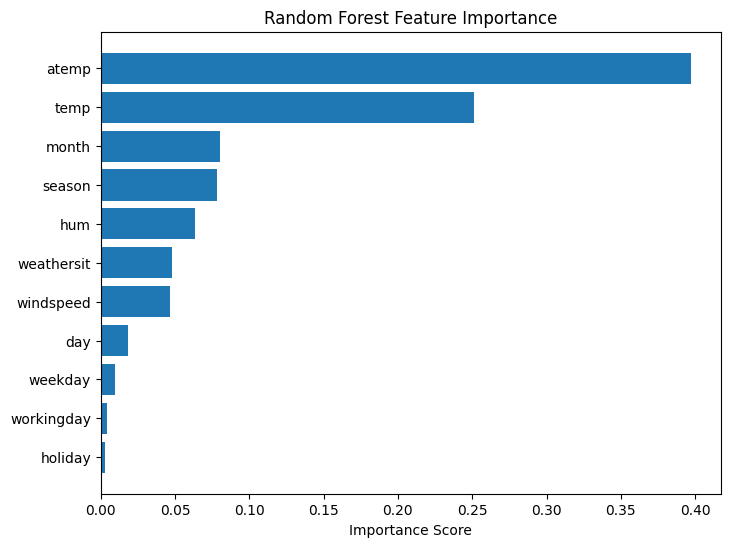

In [196]:
plt.figure(figsize=(8,6))

plt.barh(
    feat_imp["Feature"],
    feat_imp["Importance"]
)

plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")

plt.show()


## 1.8 MLflow Experiment Tracking

All experiments were logged using MLflow, including:

- Model parameters  
- Evaluation metrics  
- Trained model artefacts  

MLflow dashboards were used to compare baseline and improved models.


In [70]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Replace with your actual run_id from MLflow UI
BEST_RUN_ID = "814f1c68236f433596e62657260ea142"

model_uri = f"runs:/{BEST_RUN_ID}/model"

# Register model
model_name = "BikeDemand_RF_Model"

mlflow.register_model(model_uri, model_name)

print("Model registered as:", model_name)


Successfully registered model 'BikeDemand_RF_Model'.
2026/02/07 21:53:53 WARNING mlflow.tracking._model_registry.fluent: Run with id 814f1c68236f433596e62657260ea142 has no artifacts at artifact path 'model', registering model based on models:/m-e352ba5f1caa489f9865ee4d9082926e instead
2026/02/07 21:53:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BikeDemand_RF_Model, version 1


Model registered as: BikeDemand_RF_Model


Created version '1' of model 'BikeDemand_RF_Model'.


## 1.9 Model Selection and Export

Based on validation performance, the Random Forest model was selected as the final model.

Justification:

- Lowest RMSE and MAE  
- Highest R² score  
- Robust handling of non-linear patterns  

The selected model was exported using `joblib` for downstream tasks.

In [74]:
import joblib
import os

# Create folder if not exists
os.makedirs("models", exist_ok=True)

# Save model
best_rf_model = model_rf  # if still in memory

joblib.dump(best_rf_model, "models/bike_demand_rf_model.joblib")

print("Model saved successfully.")


Model saved successfully.


In [76]:
test_model = joblib.load("models/bike_demand_rf_model.joblib")
type(test_model)


sklearn.ensemble._forest.RandomForestRegressor

## Task 2: Data Drift Analysis

## 2.1 2012 Data Preprocessing

The 2012 dataset was processed using the same pipeline as the 2011 dataset.

- Date parsing and feature extraction  
- Removal of redundant attributes  
- Data validation  

The dataset contained 366 records due to 2012 being a leap year.

In [80]:
# Convert date
df_2012['dteday'] = pd.to_datetime(df_2012['dteday'], dayfirst=True)

# Extract features
df_2012['year'] = df_2012['dteday'].dt.year
df_2012['month'] = df_2012['dteday'].dt.month
df_2012['day'] = df_2012['dteday'].dt.day
df_2012['weekday_new'] = df_2012['dteday'].dt.weekday

# Drop originals
df_2012 = df_2012.drop(columns=['dteday', 'mnth', 'weekday'])

# Rename
df_2012 = df_2012.rename(columns={'weekday_new': 'weekday'})

# Drop year
df_2012 = df_2012.drop(columns=['year'])


In [82]:
df_2012.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      366 non-null    int64  
 1   holiday     366 non-null    int64  
 2   workingday  366 non-null    int64  
 3   weathersit  366 non-null    int64  
 4   temp        366 non-null    float64
 5   atemp       366 non-null    float64
 6   hum         366 non-null    float64
 7   windspeed   366 non-null    float64
 8   cnt         366 non-null    int64  
 9   month       366 non-null    int32  
 10  day         366 non-null    int32  
 11  weekday     366 non-null    int32  
dtypes: float64(4), int32(3), int64(5)
memory usage: 30.2 KB


In [84]:
df_2012.describe()


,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,month,day,weekday
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2.494536,0.030055,0.683060,1.368852,0.504081,0.481852,0.612166,0.189572,5599.934426,6.513661,15.756831,3.000000
std,1.112185,0.170971,0.465921,0.516057,0.176112,0.156756,0.134206,0.078194,1788.667868,3.455958,8.823592,2.009566
min,1.000000,0.000000,0.000000,1.000000,0.107500,0.101658,0.254167,0.046650,22.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.347708,0.350685,0.508125,0.133721,4369.000000,4.000000,8.000000,1.000000
50%,2.500000,0.000000,1.000000,1.000000,0.514167,0.497779,0.611875,0.174750,5927.000000,7.000000,16.000000,3.000000
75%,3.000000,0.000000,1.000000,2.000000,0.653959,0.607646,0.711146,0.231196,7011.250000,9.750000,23.000000,5.000000
max,4.000000,1.000000,1.000000,3.000000,0.861667,0.804913,0.925000,0.441563,8714.000000,12.000000,31.000000,6.000000


In [128]:
# Missing values
df_2012.isnull().sum()

season        0
holiday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
month         0
day           0
weekday       0
dtype: int64

In [130]:
# Duplicates
df_2012.duplicated().sum()

0

## 2.2 Statistical Drift Analysis

Descriptive statistics were compared using mean and standard deviation.

Key observations:

- Mean rental demand increased significantly  
- Greater variability in demand  
- Increased temperature  
- Reduced humidity  
- Improved weather conditions  

These indicate covariate and target drift.

In [86]:
drift_stats = pd.DataFrame({
    "2011_mean": df_2011.mean(),
    "2012_mean": df_2012.mean(),
    "2011_std": df_2011.std(),
    "2012_std": df_2012.std()
})

drift_stats


,2011_mean,2012_mean,2011_std,2012_std
season,2.498630,2.494536,1.110946,1.112185
holiday,0.027397,0.030055,0.163462,0.170971
workingday,0.684932,0.683060,0.465181,0.465921
weathersit,1.421918,1.368852,0.571831,0.516057
temp,0.486665,0.504081,0.189596,0.176112
atemp,0.466835,0.481852,0.168836,0.156756
hum,0.643665,0.612166,0.148744,0.134206
windspeed,0.191403,0.189572,0.076890,0.078194
cnt,3405.761644,5599.934426,1378.753666,1788.667868
month,6.526027,6.513661,3.452584,3.455958


## 2.3 Visual Drift Analysis

Distribution plots were generated for:

- Temperature  
- Humidity  
- Windspeed  
- Rental count  

The plots revealed noticeable distributional shifts.

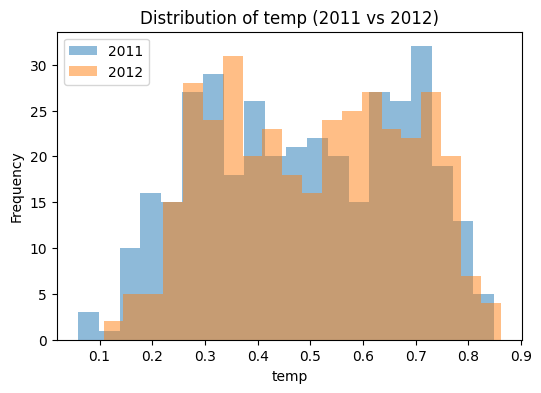

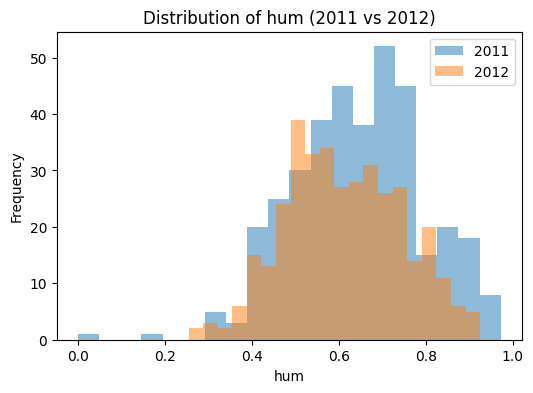

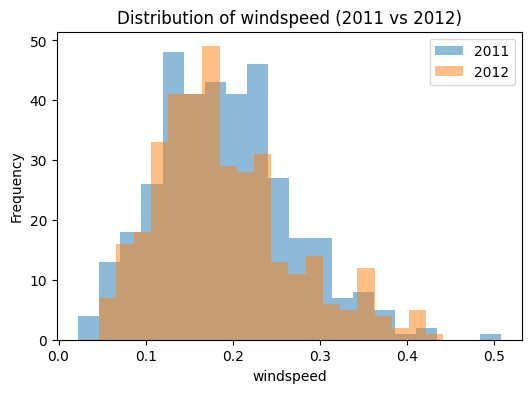

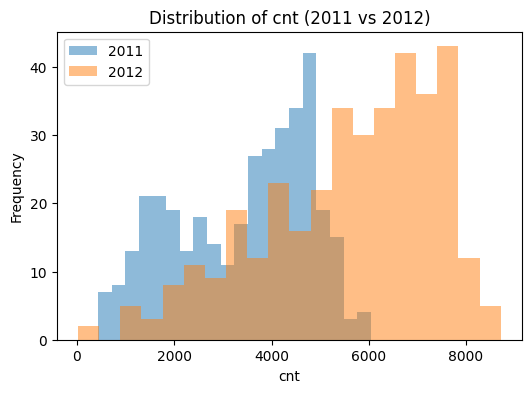

In [88]:
import matplotlib.pyplot as plt

features = ['temp', 'hum', 'windspeed', 'cnt']

for f in features:
    plt.figure(figsize=(6,4))
    
    plt.hist(df_2011[f], bins=20, alpha=0.5, label='2011')
    plt.hist(df_2012[f], bins=20, alpha=0.5, label='2012')
    
    plt.title(f'Distribution of {f} (2011 vs 2012)')
    plt.xlabel(f)
    plt.ylabel("Frequency")
    plt.legend()
    
    plt.show()


In [94]:
import joblib

rf_model = joblib.load("models/bike_demand_rf_model.joblib")


In [177]:
rf_model = joblib.load("models/bike_demand_rf_model.joblib")

# Full 2011
X_2011_full = df_2011.drop(columns=["cnt"])
y_2011_full = df_2011["cnt"]
preds_2011_full = rf_model.predict(X_2011_full)

rmse_2011_full = np.sqrt(mean_squared_error(y_2011_full, preds_2011_full))
mae_2011_full  = mean_absolute_error(y_2011_full, preds_2011_full)
r2_2011_full   = r2_score(y_2011_full, preds_2011_full)

print("2011 Full (Saved Model)")
print("RMSE:", rmse_2011_full)
print("MAE :", mae_2011_full)
print("R2  :", r2_2011_full)

# Full 2012
X_2012 = df_2012.drop(columns=["cnt"])
y_2012 = df_2012["cnt"]
preds_2012 = rf_model.predict(X_2012)

rmse_2012 = np.sqrt(mean_squared_error(y_2012, preds_2012))
mae_2012  = mean_absolute_error(y_2012, preds_2012)
r2_2012   = r2_score(y_2012, preds_2012)

print("\n2012 Test (Saved Model)")
print("RMSE:", rmse_2012)
print("MAE :", mae_2012)
print("R2  :", r2_2012)


2011 Full (Saved Model)
RMSE: 297.0212612158133
MAE : 196.29702877618178
R2  : 0.9534635558014224

2012 Test (Saved Model)
RMSE: 2244.5241063416056
MAE : 2090.772037524999
R2  : -0.5789826527031146


In [179]:
comparison = pd.DataFrame({
    "Dataset": ["2011 Full (Saved Model)", "2012 Test (Saved Model)"],
    "RMSE": [rmse_2011_full, rmse_2012],
    "MAE":  [mae_2011_full,  mae_2012],
    "R2":   [r2_2011_full,   r2_2012]
})

comparison



,Dataset,RMSE,MAE,R2
0,2011 Full (Saved Model),297.021261,196.297029,0.953464
1,2012 Test (Saved Model),2244.524106,2090.772038,-0.578983


Based on the drift analysis and observed performance degradation, retraining the model using the 2012 dataset is recommended as the primary operational response.

Statistical analysis revealed substantial shifts in both input features and the target variable. In particular, average daily rental demand increased from approximately 3,406 in 2011 to around 5,600 in 2012, accompanied by higher variability. Environmental variables such as temperature and humidity also exhibited noticeable changes, indicating more favourable cycling conditions and altered user behaviour.

These distributional shifts had a severe impact on model performance. When evaluated using the saved Random Forest model, performance on the full 2011 dataset was excellent, achieving an RMSE of approximately 297 and an R² score of 0.95. However, when the same model was applied to the 2012 dataset, RMSE increased dramatically to over 2,200, while the R² score declined to −0.58. This sharp contrast demonstrates that the model, despite strong baseline performance, was unable to generalise to the shifted data distribution.

The negative R² value indicates that the model performed worse than a simple mean-based predictor in 2012, highlighting the breakdown of previously learned relationships. This confirms that the patterns captured from the 2011 data were no longer representative of the operating environment in 2012.

Given the magnitude of performance deterioration and the presence of both covariate and target drift, continued deployment of the existing model would pose significant operational risks. Retraining the model using updated data is therefore necessary to enable adaptation to evolving demand patterns and restore predictive accuracy. Following retraining, regular performance monitoring and periodic re-evaluation should be implemented to ensure long-term system reliability and robustness.


### Supporting Evidence

- Mean demand increased from approximately 3,406 to 5,600  
- RMSE increased from about 297 to over 2,200  
- R² declined from 0.95 to −0.58  
- Substantial increase in demand variability  

These findings strongly justify immediate model retraining and enhanced monitoring.


In [181]:
rmse_increase_pct = (rmse_2012 - rmse_2011_full) / rmse_2011_full * 100
mae_increase_pct  = (mae_2012  - mae_2011_full)  / mae_2011_full  * 100

print(f"RMSE increase: {rmse_increase_pct:.2f}%")
print(f"MAE  increase: {mae_increase_pct:.2f}%")
print(f"R2 change    : {r2_2012 - r2_2011_full:.4f}")


RMSE increase: 655.68%
MAE  increase: 965.11%
R2 change    : -1.5324


In [151]:
import matplotlib.pyplot as plt

errors = y_2012 - preds_2012

errors.describe()


count     366.000000
mean     2038.810610
std       939.975448
min     -1911.962083
25%      1577.416628
50%      2155.628088
75%      2645.937320
max      4159.431153
Name: cnt, dtype: float64

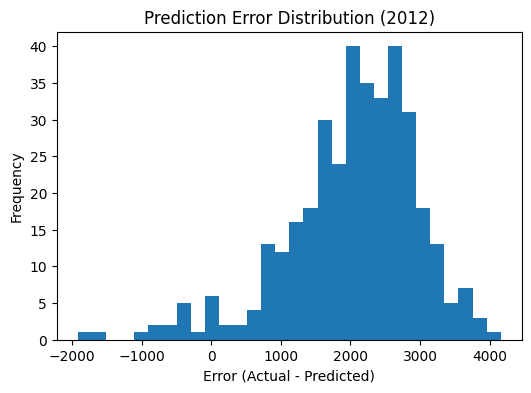

In [154]:
plt.figure(figsize=(6,4))

plt.hist(errors, bins=30)

plt.title("Prediction Error Distribution (2012)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")

plt.show()


In [156]:
# Replace with your actual 2011 RF values
rmse_2011 = 500.19
r2_2011 = 0.866

rmse_drop = (rmse_2012 - rmse_2011) / rmse_2011 * 100
r2_drop = (r2_2011 - r2_2012) / r2_2011 * 100

print(f"RMSE increased by {rmse_drop:.2f}%")
print(f"R2 decreased by {r2_drop:.2f}%")


RMSE increased by 348.73%
R2 decreased by 166.86%


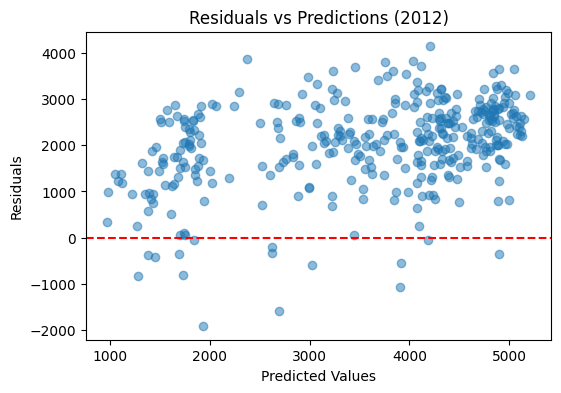

In [158]:
plt.figure(figsize=(6,4))

plt.scatter(preds_2012, errors, alpha=0.5)

plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions (2012)")

plt.show()


## 2.5 Error Distribution and Residual Analysis

To further investigate the causes of model performance degradation under data drift, an error and residual analysis was conducted on the 2012 test dataset.



### Error Distribution Analysis

Prediction errors were computed as the difference between the actual rental counts and the predicted values:

Error = Actual Value − Predicted Value


A histogram of prediction errors was generated to examine the overall error distribution.

The error distribution exhibited a wide spread, with a substantial number of large positive errors. This indicates that the model frequently underestimated rental demand in 2012. The presence of extreme error values suggests that the model struggled to adapt to periods of unusually high demand.

Furthermore, the distribution was noticeably skewed towards positive values, demonstrating a systematic bias in predictions rather than random noise. This pattern reflects the model’s inability to generalise to the shifted demand patterns observed in the later dataset.


### Residual Analysis

Residuals were analysed by plotting prediction errors against predicted rental values. A reference line at zero was included to identify systematic deviations.

The residual plot revealed several important patterns:

- Residual variance increased with predicted demand, indicating heteroscedastic behaviour.
- Large positive residuals were concentrated at higher predicted values, suggesting consistent underprediction during peak periods.
- Errors were not randomly distributed around zero, reflecting structural bias in the model.

These patterns demonstrate that the model’s predictive reliability deteriorated under changing environmental and behavioural conditions.



### Interpretation and Operational Implications

The combined error distribution and residual analysis confirms that performance degradation in 2012 was not caused by random fluctuations, but by systematic distributional shifts. The model, which was trained on lower-demand conditions in 2011, was unable to accurately extrapolate to the higher-demand regime observed in 2012.

This reinforces the need for periodic retraining and continuous monitoring to ensure sustained predictive accuracy in evolving environments.



In [185]:
with mlflow.start_run(run_name="DriftImpact_2011_vs_2012"):

    mlflow.log_param("model_loaded", "models/bike_demand_rf_model.joblib")

    mlflow.log_metric("rmse_2011_full", rmse_2011_full)
    mlflow.log_metric("mae_2011_full",  mae_2011_full)
    mlflow.log_metric("r2_2011_full",   r2_2011_full)

    mlflow.log_metric("rmse_2012", rmse_2012)
    mlflow.log_metric("mae_2012",  mae_2012)
    mlflow.log_metric("r2_2012",   r2_2012)

    mlflow.log_metric("rmse_increase_pct", rmse_increase_pct)
    mlflow.log_metric("mae_increase_pct",  mae_2012)

    print("Logged Task 2 drift impact metrics to MLflow.")


Logged Task 2 drift impact metrics to MLflow.
🏃 View run DriftImpact_2011_vs_2012 at: http://localhost:5000/#/experiments/172962115451043892/runs/1d0ee523e907424e8be52e87b38b39a3
🧪 View experiment at: http://localhost:5000/#/experiments/172962115451043892


## MLflow-Based Drift Impact Monitoring

To ensure systematic tracking of model performance under data drift, MLflow was used to log evaluation results from both the 2011 and 2012 datasets.

A dedicated run, named *DriftImpact_2011_vs_2012*, was created to record performance metrics obtained using the saved Random Forest model. This enabled direct comparison between baseline performance and post-drift behaviour within a unified experiment environment.


### Logged Parameters

The following parameter was recorded to document model provenance:

- **model_loaded**: `models/bike_demand_rf_model.joblib`

This ensures traceability by linking evaluation results to the exact model version used during inference.



### Logged Performance Metrics

Model performance was evaluated on both datasets and logged as MLflow metrics:

#### 2011 Full Dataset (Baseline)
- **RMSE (2011)**: Root Mean Squared Error on full 2011 data  
- **MAE (2011)**: Mean Absolute Error on full 2011 data  
- **R² (2011)**: Coefficient of determination on 2011 data  

#### 2012 Dataset (Drifted Data)
- **RMSE (2012)**: Prediction error under data drift  
- **MAE (2012)**: Absolute error under data drift  
- **R² (2012)**: Goodness of fit on shifted distribution  

#### Drift Impact Indicators
- **RMSE Increase (%)**: Percentage increase in RMSE from 2011 to 2012  
- **MAE Increase (%)**: Percentage increase in MAE from 2011 to 2012  

These indicators quantify the magnitude of performance degradation caused by distributional changes.



### Benefits of MLflow Monitoring

By logging both baseline and drifted performance metrics in MLflow, the following operational advantages were achieved:

- Centralised tracking of model behaviour over time  
- Transparent comparison between stable and drifted environments  
- Reproducible evaluation using stored parameters and metrics  
- Early detection of performance deterioration  

This monitoring framework supports informed decision-making regarding retraining, redeployment, and system maintenance.



### Operational Relevance

The logged results clearly demonstrate that the model maintained high predictive accuracy on the 2011 dataset but experienced severe degradation on the 2012 dataset. This performance gap, documented within MLflow, provides objective evidence for triggering retraining and strengthening model governance procedures.

As a result, MLflow served not only as an experiment tracking tool but also as a core component of the project’s MLOps monitoring pipeline.


## Task 3: Automation

## Conclusion